In [388]:
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [374]:
# read datast(s)
with open('../data/Coaches.csv', 'rb') as f:
    coaches = pd.read_csv(f).fillna(0)

with open('../data/stadiums-geocoded.csv', 'rb') as f:
    stadium = pd.read_csv(f).fillna(0)

with open('../data/graduation-rates.csv', 'rb') as f:
    grad_rates = pd.read_csv(f).fillna(0)

with open('../data/2017-season.csv', 'rb') as f:
    season_2017 = pd.read_csv(f).fillna(0)

In [375]:
# numerical columns
stadium_numerical = ['capacity', 'built', 'expanded']
grad_numerical = ['gsr', 'fgr']
season_numerical = ['win', 'loss', 'pct']
coaches_numerical = [
    'schoolpay',
    'totalpay',
    'bonus',
    'bonuspaid',
    'assistantpay',
    'buyout'
]

# convert lowercase
coaches = coaches.apply(lambda x: x.astype(str).str.lower())
stadium = stadium.apply(lambda x: x.astype(str).str.lower())
grad_rates = grad_rates.apply(lambda x: x.astype(str).str.lower())
season_2017 = season_2017.apply(lambda x: x.astype(str).str.lower())

# column names to lowercase
coaches.columns = coaches.columns.str.lower()
stadium.columns = stadium.columns.str.lower()
grad_rates.columns = grad_rates.columns.str.lower()
season_2017.columns = season_2017.columns.str.lower()

# remove non-numeric to empty space
coaches[coaches_numerical] = coaches[coaches_numerical].replace('[\$,--]', '', regex=True)

# convert column name: allows dataframe merge
stadium = stadium.rename(columns={'team': 'school'})

# coerce monetary to numeric
stadium[stadium_numerical] = stadium[stadium_numerical].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

# coerce monetary to numeric
coaches[coaches_numerical] = coaches[coaches_numerical].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

# coerce graduation rate to numeric
grad_rates[grad_numerical] = grad_rates[grad_numerical].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

# coerce season rate to numeric
season_2017[season_numerical] = season_2017[season_numerical].apply(
    pd.to_numeric,
    errors='coerce',
    axis=1
).fillna(0)

In [376]:
# stadium only columns
stadium = stadium[['stadium', 'school'] + stadium_numerical]

# replace acronym with school name
stadium['school'] = stadium['school'].replace(['ucf'], 'central florida')
stadium['school'] = stadium['school'].replace(['usf'], 'south florida')
stadium['school'] = stadium['school'].replace(['utsa'], 'texas-san antonio')
stadium['school'] = stadium['school'].replace(['byu'], 'brigham young')
stadium['school'] = stadium['school'].replace(['utep'], 'texas-el paso')
stadium['school'] = stadium['school'].replace(['tcu'], 'texas christian')
stadium['school'] = stadium['school'].replace(['unlv'], 'nevada-las vegas')
stadium['school'] = stadium['school'].replace(['smu'], 'southern methodist')
stadium['school'] = stadium['school'].replace(['niu'], 'northern illinois')
stadium['school'] = stadium['school'].replace(['miami (oh)'], 'miami (ohio)')
stadium['school'] = stadium['school'].replace(['fiu'], 'florida international')
stadium['school'] = stadium['school'].replace(['umass'], 'massachusetts')
stadium['school'] = stadium['school'].replace(['yale bulldogs'], 'connecticut')

#
# stadium pre 2007: attraining stadium data after 2006, will not
#      join with the grad_rates dataframe, since the 2006 cohort
#      is the focus.
#
stadium = stadium[stadium['expanded'] <= 2006]

In [377]:
# merge coaches + stadium
merged_df = pd.merge(coaches, stadium, on='school', how='inner')

# merge graduation rates
merged_df = pd.merge(merged_df, grad_rates, on='school', how='inner')

# merge 2017 season
merged_df = pd.merge(merged_df, season_2017, on='school', how='inner')

In [378]:
# local variables
lin_reg = linear_model.LinearRegression()

# split train + test
train, test = train_test_split(merged_df, test_size=0.33)

#
# train model
#
y_train = train[['schoolpay']]
X_train = train[['capacity', 'gsr', 'fgr', 'win', 'loss', 'pct']]
lin_reg.fit(X_train, y_train)

#
# predict
#
y_test = test[['schoolpay']]
X_test = test[['capacity', 'gsr', 'fgr', 'win', 'loss', 'pct']]
y_pred = lin_reg.predict(X_test)

In [379]:
# predict syracuse salary
target = merged_df[merged_df['school'] == 'syracuse']
lin_reg.predict(target[['capacity', 'gsr', 'fgr', 'win', 'loss', 'pct']])

array([[1727143.87246036]])

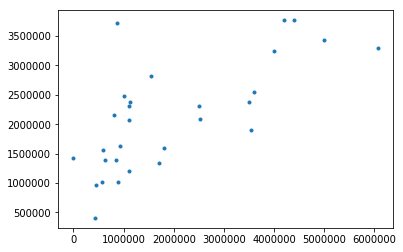

In [380]:
# prediction vs actual data
plt.plot(y_test, y_pred, '.')

In [389]:
print('model coefficients: {}\nmodel intercept: {}\nmean squared error: {}\n rsquared: {}'.format(
    lin_reg.coef_,
    lin_reg.intercept_,
    mean_squared_error(y_test, y_pred),
    r2_score(y_test, y_pred)
))

model coefficients: [[ 4.05648618e+01 -5.52070896e+03  9.91727990e+03  7.40892358e+05
  -5.56710664e+05 -1.41677205e+07]]
model intercept: [5732402.49577009]
mean squared error: 1353539764140.3342
 rsquared: 0.4658071841090238


In [383]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              schoolpay   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     11.88
Date:                Sat, 27 Oct 2018   Prob (F-statistic):           3.08e-08
Time:                        23:42:03   Log-Likelihood:                -875.22
No. Observations:                  57   AIC:                             1764.
Df Residuals:                      50   BIC:                             1779.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.732e+06   4.13e+06      1.389      0.1